In [ ]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix
from keras.layers import GRU, Dropout, Dense,BatchNormalization
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, roc_auc_score

In [ ]:
data = pd.read_csv("/content/sample_data/smart_grid_stability_augmented.csv")


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tau1    60000 non-null  float64
 1   tau2    60000 non-null  float64
 2   tau3    60000 non-null  float64
 3   tau4    60000 non-null  float64
 4   p1      60000 non-null  float64
 5   p2      60000 non-null  float64
 6   p3      60000 non-null  float64
 7   p4      60000 non-null  float64
 8   g1      60000 non-null  float64
 9   g2      60000 non-null  float64
 10  g3      60000 non-null  float64
 11  g4      60000 non-null  float64
 12  stab    60000 non-null  float64
 13  stabf   60000 non-null  object 
dtypes: float64(13), object(1)
memory usage: 6.4+ MB


In [ ]:
data

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,2.930406,2.376523,9.487627,6.187797,3.343416,-1.449106,-0.658054,-1.236256,0.601709,0.813512,0.779642,0.608385,0.023892,unstable
59996,3.392299,2.954947,1.274827,6.894759,4.349512,-0.952437,-1.663661,-1.733414,0.502079,0.285880,0.567242,0.366120,-0.025803,stable
59997,2.364034,8.776391,2.842030,1.008906,4.299976,-0.943884,-1.380719,-1.975373,0.487838,0.149286,0.986505,0.145984,-0.031810,stable
59998,9.631511,2.757071,3.994398,7.821347,2.514755,-0.649915,-0.966330,-0.898510,0.365246,0.889118,0.587558,0.818391,0.037789,unstable


In [ ]:
data=data.replace(np.nan,0)

In [ ]:
# check missing values in variables

data.isnull().sum()

tau1     0
tau2     0
tau3     0
tau4     0
p1       0
p2       0
p3       0
p4       0
g1       0
g2       0
g3       0
g4       0
stab     0
stabf    0
dtype: int64

In [ ]:
data.stabf.value_counts()

unstable    38280
stable      21720
Name: stabf, dtype: int64

In [ ]:
# Map 'unstable' to 1 and 'stable' to 0
data['stabf'] = data['stabf'].map({'unstable': 1, 'stable': 0})



# Convert the 'stabf' column to numeric
data['stabf'] = pd.to_numeric(data['stabf'], errors='coerce')

# Display the updated DataFrame
print(data.head())

       tau1      tau2      tau3      tau4        p1        p2        p3  \
0  2.959060  3.079885  8.381025  9.780754  3.763085 -0.782604 -1.257395   
1  9.304097  4.902524  3.047541  1.369357  5.067812 -1.940058 -1.872742   
2  8.971707  8.848428  3.046479  1.214518  3.405158 -1.207456 -1.277210   
3  0.716415  7.669600  4.486641  2.340563  3.963791 -1.027473 -1.938944   
4  3.134112  7.608772  4.943759  9.857573  3.525811 -1.125531 -1.845975   

         p4        g1        g2        g3        g4      stab  stabf  
0 -1.723086  0.650456  0.859578  0.887445  0.958034  0.055347      1  
1 -1.255012  0.413441  0.862414  0.562139  0.781760 -0.005957      0  
2 -0.920492  0.163041  0.766689  0.839444  0.109853  0.003471      1  
3 -0.997374  0.446209  0.976744  0.929381  0.362718  0.028871      1  
4 -0.554305  0.797110  0.455450  0.656947  0.820923  0.049860      1  


In [ ]:
X = data.drop(['stabf'], axis=1)
y = data['stabf']

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)






In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build GRU model
model = Sequential()
model.add(GRU(units=128, input_shape=(X_train_scaled.shape[1], 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=64))
model.add(Dropout(0.1))
model.add(Dense(units=1, activation='sigmoid'))


In [ ]:

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history= model.fit(X_train_scaled, y_train, epochs=5, batch_size=32, validation_split=0.1)



Epoch 1/5
1350/1350 [==============================] - 37s 25ms/step - loss: 0.0538 - accuracy: 0.9777 - val_loss: 0.0134 - val_accuracy: 0.9956
Epoch 2/5
1350/1350 [==============================] - 33s 24ms/step - loss: 0.0144 - accuracy: 0.9941 - val_loss: 0.0113 - val_accuracy: 0.9933
Epoch 3/5
1350/1350 [==============================] - 35s 26ms/step - loss: 0.0106 - accuracy: 0.9958 - val_loss: 0.0055 - val_accuracy: 0.9996
Epoch 4/5
1350/1350 [==============================] - 32s 24ms/step - loss: 0.0085 - accuracy: 0.9963 - val_loss: 0.0049 - val_accuracy: 0.9990
Epoch 5/5
1350/1350 [==============================] - 34s 25ms/step - loss: 0.0068 - accuracy: 0.9970 - val_loss: 0.0049 - val_accuracy: 0.9983


In [ ]:
y_pred=model.predict(X_test_scaled)

375/375 [==============================] - 8s 15ms/step


In [ ]:
accu=accuracy_score(y_test,y_pred.round())
print("Accuracy Score :")
print(accu)

Accuracy Score :
0.99925


AUC: 1.00


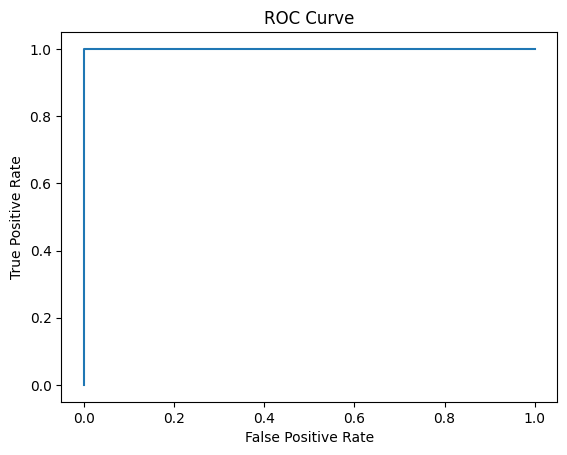

In [ ]:
# Calculate the ROC Precision, Recall, and F1-Score
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_fscore_support
import matplotlib.pyplot as plt
# Calculate the AUC
auc = roc_auc_score(y_test, y_pred.round())
print('AUC: %.2f' % auc)

# Calculate the ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)


# plot the roc curve
plt.plot(fpr, tpr)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [ ]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred.round())

# Print the confusion matrix
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[4313    9]
 [   0 7678]]


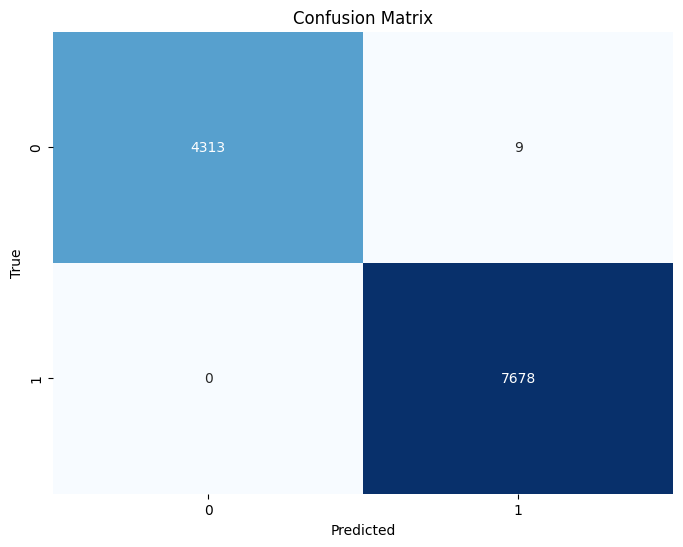

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred.round()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4322
           1       1.00      1.00      1.00      7678

    accuracy                           1.00     12000
   macro avg       1.00      1.00      1.00     12000
weighted avg       1.00      1.00      1.00     12000



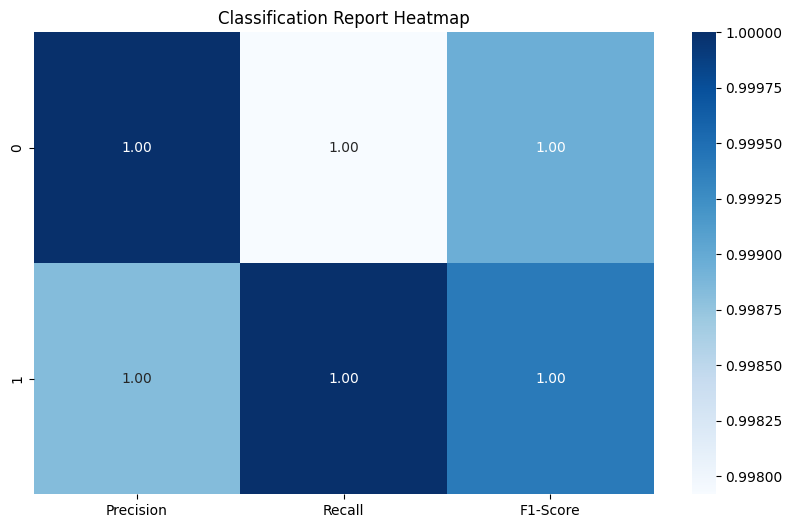

In [ ]:
# Plotting a heatmap for precision, recall, and F1-score
class_report = classification_report(y_test, y_pred.round(), output_dict=True)
class_names = [str(label) for label in class_report.keys() if label not in ['accuracy', 'macro avg', 'weighted avg']]

# Extract precision, recall, and F1-score for each class
heatmap_data = [[class_report[class_name]['precision'], class_report[class_name]['recall'], class_report[class_name]['f1-score']] for class_name in class_names]

# Create a heatmap
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", xticklabels=['Precision', 'Recall', 'F1-Score'], yticklabels=class_names, cmap='Blues')
plt.title('Classification Report Heatmap')
plt.show()

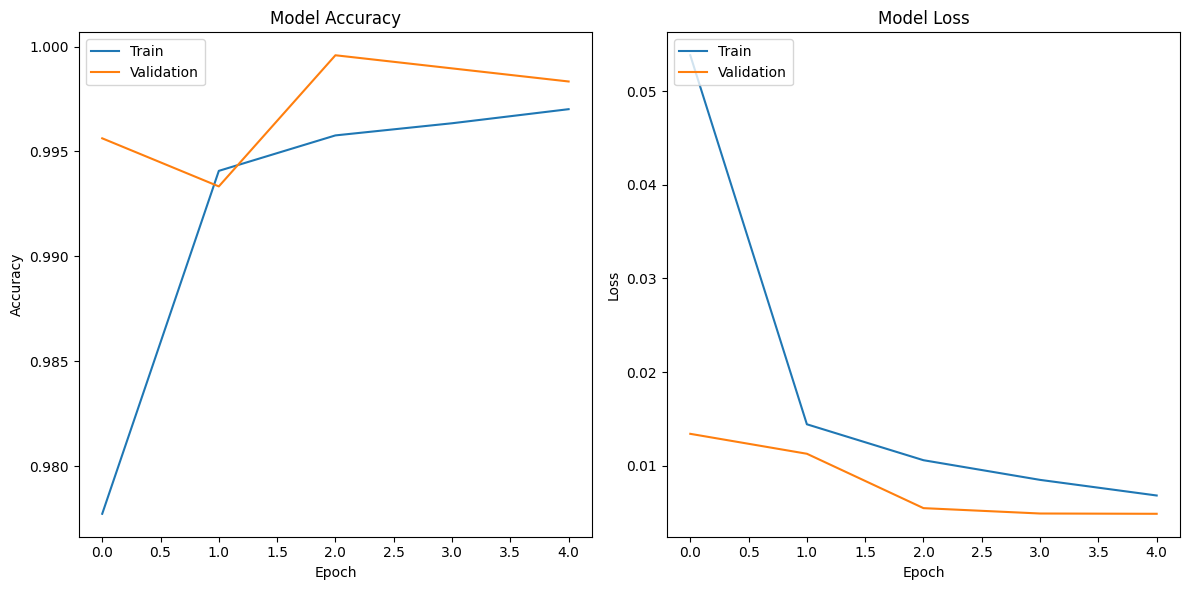

In [ ]:
import matplotlib.pyplot as plt

# Train the model
#history = model.fit(X_train_scaled, y_train, epochs=5, batch_size=32, validation_split=0.1)

# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()
